In [3]:
import torchvision.models as models

# 利用可能な事前学習済みモデル一覧を表示
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))

print(model_names)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'get_model', 'get_model_builder', 'get_model_weights', 'get_weight', 'googlenet', 'inception_v3', 'list_models', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import time
import os
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
# データのディレクトリ設定
data_dir = "/home/dataset/leaf_dataset/train"

# データの前処理設定(学習時と検証時)
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# データセットの読み込み
dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# 8:2でデータセットを分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# データローダー設定
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloaders = {"train": train_loader, "val": val_loader}

# クラス数の取得
class_names = dataset.classes
num_classes = len(class_names)

In [12]:
# GPUの確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Vision Transformerのロード
model = vit_b_16(pretrained=True)

# 出力層を葉の病害分類用に変更
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# モデルをGPUに転送
model = model.to(device)

# 損失関数とオプティマイザの設定
criterion = nn.CrossEntropyLoss()

# 全てのパラメータを微分可能に設定
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習率の減少スケジューラ
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 訓練用関数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        # 各エポックでの学習フェーズと評価フェーズ
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else: 
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # バッチごとのデータ処理
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 勾配のリセット
                optimizer.zero_grad()

                # 順伝播
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 訓練フェーズではバックプロパゲーション + 最適化
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # ロスと正解数の統計
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == "train":
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # 最良のモデルをコピー
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 68:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")
    
    # 最良モデルの重みをロード
    model.load_state_dict(best_model_wts)
    return model

# モデルの訓練
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

# 訓練後のモデル保存
torch.save(model.state_dict(), "/home/weights/vit_b_16.pth")

/usr/local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 1.1709 Acc: 0.6206
val Loss: 1.1347 Acc: 0.6123

Epoch 1/24
----------
train Loss: 1.0899 Acc: 0.6318
val Loss: 1.0894 Acc: 0.6236

Epoch 2/24
----------
train Loss: 1.0292 Acc: 0.6399
val Loss: 1.0116 Acc: 0.6387

Epoch 3/24
----------
train Loss: 0.9855 Acc: 0.6468
val Loss: 0.9877 Acc: 0.6387

Epoch 4/24
----------
train Loss: 0.9447 Acc: 0.6540
val Loss: 0.9345 Acc: 0.6486

Epoch 5/24
----------
train Loss: 0.9135 Acc: 0.6606
val Loss: 0.9177 Acc: 0.6563

Epoch 6/24
----------
train Loss: 0.9098 Acc: 0.6649
val Loss: 0.9129 Acc: 0.6571

Epoch 7/24
----------
train Loss: 0.8520 Acc: 0.6861
val Loss: 0.8665 Acc: 0.6769

Epoch 8/24
----------
train Loss: 0.8369 Acc: 0.6903
val Loss: 0.8355 Acc: 0.6874

Epoch 9/24
----------
train Loss: 0.8212 Acc: 0.6919
val Loss: 0.8462 Acc: 0.6852

Epoch 10/24
----------
train Loss: 0.8225 Acc: 0.6954
val Loss: 0.8406 Acc: 0.6885

Epoch 11/24
----------
train Loss: 0.8186 Acc: 0.6967
val Loss: 0.8195 Acc: 0.6923

Ep

/usr/local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_24337/978684352.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functi

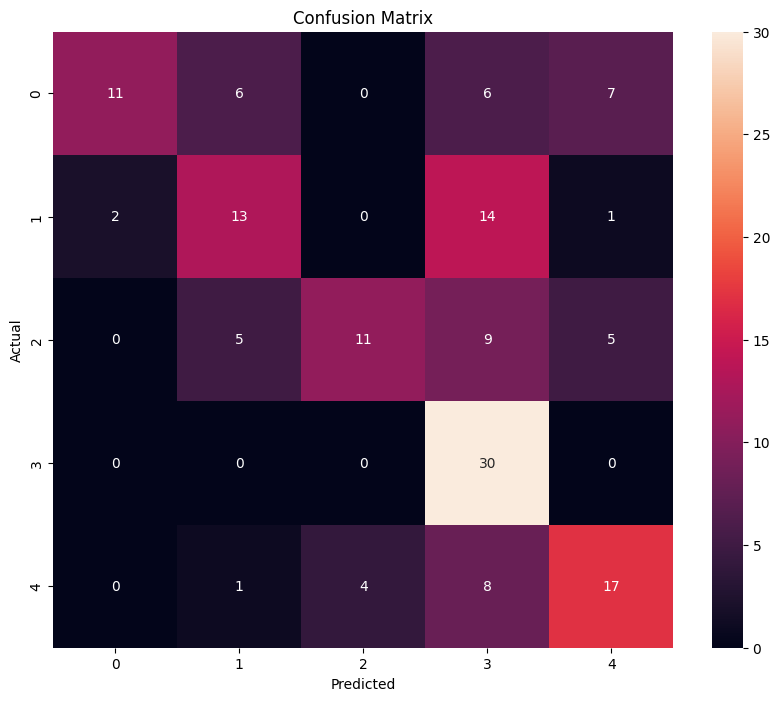

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.37      0.51        30
           1       0.52      0.43      0.47        30
           2       0.73      0.37      0.49        30
           3       0.45      1.00      0.62        30
           4       0.57      0.57      0.57        30

    accuracy                           0.55       150
   macro avg       0.62      0.55      0.53       150
weighted avg       0.62      0.55      0.53       150



In [21]:
# モデルの評価

# データのディレクトリ設定(評価用)
eval_dir = "/home/dataset/check"

# 評価データの前処理設定
eval_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 評価データセットの読み込み
eval_dataset = datasets.ImageFolder(eval_dir, transform=eval_transforms)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, num_workers=4)

# GPUの確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの読み込み
model = vit_b_16(pretrained=False)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
model.load_state_dict(torch.load("/home/weights/vit_b_16.pth"))
model = model.to(device)
model.eval()  # モデルを評価モードに設定

# 評価の実行
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in eval_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 予測
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # ラベルと予測結果の保存
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 混同行列の作成
cm = confusion_matrix(all_labels, all_preds)

# 混同行列の表示
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

# 詳細な分類レポートを表示
print("Classification Report: ")
print(classification_report(all_labels, all_preds, target_names=class_names))